In [1]:
import torch
import numpy as np
import os
import librosa as lb
import mimetypes
from pathlib import Path
from functools import partial
from typing import Optional, Union, Tuple
from fastcore.all import *
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import albumentations as A
from timm import create_model
# from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from nnAudio import features
from sklearn.metrics import roc_auc_score
import kornia as K
import fastprogress
from torch import optim
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '/home/ubuntu/data/fan'

In [4]:
get_ext = lambda x: [i for i,j in mimetypes.types_map.items() if j.startswith(x)]

image_ext = get_ext('image')
video_ext = get_ext('video')
text_ext = get_ext('text')
audio_ext = get_ext('audio')

join_path = lambda x, y: Path(os.path.join(x, y))

def get_files(root: Union[str, Path], 
        file_type: Union[str, Tuple[str, ...]]=None,
        recursive: Optional[bool]=True, 
        generator: Optional[bool]=False):
    files = []
    if file_type: file_type = tuple(file_type)
    if not recursive:
        files.extend([join_path(root, i) for i in 
            os.listdir(root) if str(i).lower().endswith(file_type)])
    else:
        for p, d, fs in os.walk(root):
            if file_type:
                files.extend([join_path(p, f) for f in fs if str(f).lower().endswith(file_type)])
            else:
                files.extend([join_path(p, f) for f in fs])
    return L(files) if bool else iter(files)


get_image_files = partial(get_files, file_type= image_ext)
get_video_files = partial(get_files, file_type= video_ext)
get_text_files = partial(get_files, file_type= text_ext)
get_audio_files = partial(get_files, file_type= audio_ext)

In [5]:
fs = get_audio_files(data_path)
normal_fs = fs.filter(lambda x: x.parent.name=='normal')
abnormal_fs = fs.filter(lambda x: x.parent.name=='abnormal')

In [7]:
# out = file_load(fs[1])
# out[0].shape, out[1]

In [8]:
def file_load(wav_name, mono=False):
    return lb.load(wav_name, sr=None, mono=mono)

def demux_wav(wav_name, channel=0):
    multi_channel_data, sr = file_load(wav_name)
    if multi_channel_data.ndim <= 1: return sr, multi_channel_data
    return sr, np.array(multi_channel_data)[channel, :]

def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(file_name)
    mel_spectrogram = lb.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return np.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = np.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray

In [9]:
def list_to_vector_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 loop of file_to_vectorarray
    for idx in range(len(file_list)):

        vector_array = file_to_vector_array(file_list[idx],
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = np.zeros((vector_array.shape[0] * len(file_list), dims), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

    return torch.tensor(dataset)

In [10]:
def get_dataloader(idno):
    fs = get_audio_files(os.path.join('/home/ubuntu/data/fan', idno))
    normal_fs = fs.filter(lambda x: x.parent.name=='normal')
    abnormal_fs = fs.filter(lambda x: x.parent.name=='abnormal')
    train_fs, val_fs = train_test_split(normal_fs)
    train_ds = list_to_vector_array(train_fs)
    val_ds = list_to_vector_array(val_fs)

    train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, pin_memory=True, num_workers=4, drop_last=True)
    val_dl = DataLoader(val_ds, batch_size=512, shuffle=True, pin_memory=True, num_workers=4)
    return train_dl, val_dl, val_fs, abnormal_fs

In [11]:
def get_dataset(fold, normal=True):
    kf = StratifiedKFold(5, random_state=13, shuffle=True)
    fs = get_audio_files(data_path)
    fs = fs.filter(lambda x: x.parent.name=='normal' if normal else 'abnormal')
    for k, (train_ids, val_ids) in enumerate(kf.split(fs, fs.map(lambda x: x.parent.name))):
        if k == fold: return SpecDataset(fs[train_ids]), SpecDataset(fs[val_ids])
    
def get_test_dl():
    fs = get_audio_files(data_path)
    fs = fs.filter(lambda x: x.parent.name=='abnormal')
    return DataLoader(SpecDataset(fs), bs=512, pin_memory=True, num_workers=4)

In [12]:
def get_vae_model():
    model = nn.Sequential(
        nn.BatchNorm1d(320),
        nn.Linear(320, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 8),
        nn.ReLU(),
        nn.Linear(8, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 320)).cuda()
    return model

In [11]:
# class PreProcCB(Callback):
#     def before_batch(self):
#         self.learn.xb = (self.xb[0].view(-1, 320).float(),)
#         self.learn.yb = (self.yb[0].view(-1, 320).float(),)

In [15]:
epochs = 100

data_path = '/home/ubuntu/data/fan'
stat_dict = dict()
for idno in os.listdir(data_path):
# for idno in ['id_00']:
    train_dl, val_dl, val_fs, abnormal_fs = get_dataloader(idno)
    model = get_vae_model()
    opt = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        train_acc, val_acc = [], []
        model.train()
        for k, (xb) in enumerate(train_dl):
            xb = xb.T.flatten(1).T.float().cuda()
            pred = model(xb)
            loss = F.mse_loss(pred, xb)
            train_acc.append(loss.mean().item())
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            for k, (xb) in enumerate(val_dl):
                xb = xb.T.flatten(1).T.float().cuda()
                pred = model(xb)
                loss = F.mse_loss(pred, xb)
                val_acc.append(loss.mean().item())
        if epoch % 20 == 0: print(epoch, np.array(train_acc).mean(), np.array(val_acc).mean())
        
    val_acc = []
    for item in val_fs:
        inp = torch.from_numpy(file_to_vector_array(item)).cuda().float()
        val_acc.append(torch.mean(torch.square(inp - model(inp)), axis=1).mean().item())
    val_acc = np.array(val_acc)
    
    abnormal_acc = []
    for item in abnormal_fs:
        inp = torch.from_numpy(file_to_vector_array(item)).cuda().float()
        abnormal_acc.append(torch.mean(torch.square(inp - model(inp)), axis=1).mean().item())
    
    abnormal_acc = np.array(abnormal_acc)
    normal_vals, normal_targets = np.abs(val_acc - val_acc.mean())/val_acc.std(), np.zeros_like(val_acc)
    abnormal_vals, abnormal_targets = np.abs(abnormal_acc - val_acc.mean())/val_acc.std(), np.ones_like(abnormal_acc)
    stat_dict[idno] = {'mean': val_acc.mean(), 'std': val_acc.std(), 'normal_mean': normal_vals.mean(), 'normal_std': normal_vals.std()}
    print(np.unique(np.concatenate([normal_vals, abnormal_vals]) > normal_vals.mean() + normal_vals.std(), return_counts=True))
    print(idno, roc_auc_score(np.concatenate([normal_vals, abnormal_vals]) > normal_vals.mean() + normal_vals.std(), 
                              np.concatenate([normal_targets, abnormal_targets])))
    torch.save(model.state_dict(), f'model_{idno}.pth')

0 161.30498465429793 13.61529929774582
20 5.445146947652421 5.343599565469535
40 5.381173160397776 5.343428985328432
60 5.318396388590974 5.21998676980377
80 5.266455416505801 5.173883231582155
(array([False,  True]), array([298, 309]))
id_04 0.8620523012097913
0 158.9797907311932 14.380617791956121
20 4.844856436735665 4.75005546173492
40 4.661952157945155 4.5753401533349765
60 4.547903000659153 4.46207020809124
80 4.503927725332755 4.4515147518802
(array([False,  True]), array([238, 377]))
id_06 0.9787798408488064
0 144.46146346281296 11.108984581835859
20 5.371012775986283 5.41124127437542
40 5.283383234393883 5.3019843968478115
60 5.234140309892709 5.234001729395483
80 5.2149799934919105 5.210710033193811
(array([False,  True]), array([239, 374]))
id_02 0.9799465240641712
0 196.66892580495622 20.686363955728368
20 5.685819026938674 5.571377810309915
40 5.54637345808601 5.490440346836265
60 5.450759505808223 5.384240602356156
80 5.4021585253709254 5.329593848558813
(array([False,  T

In [19]:
import json

with open('model_stats.json', 'w+') as f_out:
    json.dump(stat_dict, f_out, indent=4)

In [20]:
with open('model_stats.json', 'r+') as f_in:
    stat_dict = json.load(f_in)

In [21]:
stat_dict

{'id_04': {'mean': 5.140185948964712,
  'std': 0.3677342813898396,
  'normal_mean': 0.7545354805163678,
  'normal_std': 0.6562592541381294},
 'id_06': {'mean': 4.413740190934009,
  'std': 0.4748257903047574,
  'normal_mean': 0.6879852254030572,
  'normal_std': 0.7257246927224571},
 'id_02': {'mean': 5.199724843182902,
  'std': 0.27132566890592325,
  'normal_mean': 0.7260894119648542,
  'normal_std': 0.6876002951079446},
 'id_00': {'mean': 5.33057733392527,
  'std': 0.821168818417859,
  'normal_mean': 0.6635359707191701,
  'normal_std': 0.748144381494487}}

In [22]:
def load_weights(machine_id):
    m = get_vae_model()
    m.load_state_dict(torch.load(f'model_{machine_id}.pth'))
    m = m.eval()
    m = m.float()
    m = m.cuda()
    return m

In [23]:
models = {i: load_weights(i) for i in sorted(os.listdir(data_path))}

In [26]:
def predict(machine_number, file_name):
    inp = torch.from_numpy(file_to_vector_array(file_name)).cuda().float()
    prediction_map = {True: 'abnormal', False: 'normal'}
    return prediction_map[abs(torch.mean(torch.square(inp - models[machine_number](inp)), axis=1).mean().item() - 
               stat_dict[machine_number]['mean'])/stat_dict[machine_number]['std'] > 
                          stat_dict[machine_number]['normal_mean'] + stat_dict[machine_number]['normal_std']]

In [27]:
fs

(#5550) [Path('/home/ubuntu/data/fan/id_04/normal/00000456.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000667.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000300.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000989.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000047.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000362.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000801.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000417.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000043.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000648.wav')...]

In [35]:
Counter(fs.filter(lambda x: x.parent.parent.name == "id_00").map(lambda x: x.parent.name))

Counter({'normal': 1011, 'abnormal': 407})

In [28]:
from collections import Counter
acc_00 = [predict('id_00', o)  for o in fs.filter(lambda x: x.parent.parent.name == "id_00")]
Counter(acc_00)

Counter({'normal': 1197, 'abnormal': 221})

In [36]:
Counter(fs.filter(lambda x: x.parent.parent.name == "id_02").map(lambda x: x.parent.name))

Counter({'normal': 1016, 'abnormal': 359})

In [29]:
acc_02 = [predict('id_02', o)  for o in fs.filter(lambda x: x.parent.parent.name == "id_02")]
Counter(acc_02)

Counter({'normal': 940, 'abnormal': 435})

In [37]:
Counter(fs.filter(lambda x: x.parent.parent.name == "id_04").map(lambda x: x.parent.name))

Counter({'normal': 1033, 'abnormal': 348})

In [30]:
acc_04 = [predict('id_04', o)  for o in fs.filter(lambda x: x.parent.parent.name == "id_04")]
Counter(acc_04)

Counter({'normal': 984, 'abnormal': 397})

In [38]:
Counter(fs.filter(lambda x: x.parent.parent.name == "id_06").map(lambda x: x.parent.name))

Counter({'normal': 1015, 'abnormal': 361})

In [31]:
acc_06 = [predict('id_06', o)  for o in fs.filter(lambda x: x.parent.parent.name == "id_06")]
Counter(acc_06)

Counter({'normal': 924, 'abnormal': 452})

In [59]:
fs

(#5550) [Path('/home/ubuntu/data/fan/id_04/normal/00000456.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000667.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000300.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000989.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000047.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000362.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000801.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000417.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000043.wav'),Path('/home/ubuntu/data/fan/id_04/normal/00000648.wav')...]

In [68]:
Counter(fs.filter(lambda x: x.parent.parent.name == 'id_00').map(lambda x: x.parent.name))

Counter({'normal': 1011, 'abnormal': 407})

In [ ]:
train_acc = []
for item in train_fs:
    inp = torch.from_numpy(file_to_vector_array(item)).cuda().float()
    train_acc.append(torch.mean(torch.square(inp - model(inp)), axis=1).mean().item())

train_acc = np.array(train_acc)

NameError: name 'train_fs' is not defined

In [136]:
val_acc = []
for item in val_fs:
    inp = torch.from_numpy(file_to_vector_array(item)).cuda().float()
    val_acc.append(torch.mean(torch.square(inp - model(inp)), axis=1).mean().item())
    
val_acc = np.array(val_acc)

In [ ]:
abnormal_acc = []
for item in abnormal_fs:
    inp = torch.from_numpy(file_to_vector_array(item)).cuda().float()
    abnormal_acc.append(torch.mean(torch.square(inp - model(inp)), axis=1).mean().item())
    
abnormal_acc = np.array(abnormal_acc)

In [ ]:
train_acc.mean(), train_acc.std()

In [ ]:
val_acc.mean(), val_acc.std()

In [ ]:
abnormal_acc.mean(), abnormal_acc.std()

In [ ]:
normal_vals, normal_targets = np.abs(val_acc - val_acc.mean())/val_acc.std(), np.zeros_like(val_acc)

In [ ]:
abnormal_vals, abnormal_targets = np.abs(abnormal_acc - val_acc.mean())/val_acc.std(), np.ones_like(abnormal_acc)

In [ ]:
roc_auc_score(np.concatenate([normal_vals, abnormal_vals]) > normal_vals.mean() + normal_vals.std(), np.concatenate([normal_targets, abnormal_targets]))

In [68]:
import matplotlib.pyplot as plt

(array([137.,  84.,  12.,  50.,  20.,   9.,  21.,  12.,  11.,   3.]),
 array([ 1.45368495,  5.8904534 , 10.32722186, 14.76399032, 19.20075878,
        23.63752723, 28.07429569, 32.51106415, 36.9478326 , 41.38460106,
        45.82136952]),
 <BarContainer object of 10 artists>)

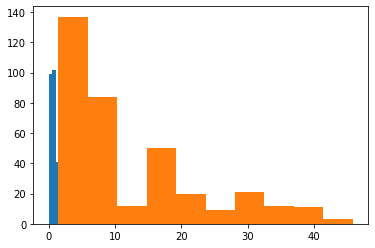

In [70]:
plt.hist(normal_vals)
plt.hist(abnormal_vals)

In [ ]:
plt.hist